In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams["figure.figsize"] = 8, 5

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

**Первичная подготовка данных: выделение новых признаков, приведение T/F признаков к числовым. Пропуски не заполняются.**

In [2]:
train_df = pd.read_csv('./data/train.csv')

train_df.drop('Name', axis=1, inplace=True)

train_df.loc[:, 'CryoSleep'] = train_df.loc[:, 'CryoSleep'].map({False: 0, True: 1})

train_df.insert(1, 'Group', train_df['PassengerId'].str.split('_').str.get(0).astype(np.int64))
group_vc = train_df['Group'].value_counts()
train_df.insert(2, 'SameGroupCount', train_df['Group'].apply(lambda x: group_vc[x] - 1))
train_df.drop('PassengerId', axis=1, inplace=True)

train_df.insert(5, 'CabinSideIsPort', train_df['Cabin'].str.split('/').str.get(2).map({'S': 0, 'P': 1}))
train_df.insert(5, 'CabinNum', train_df['Cabin'].str.split('/').str.get(1).astype('float'))

train_df.insert(5, 'CabinDeck', train_df['Cabin'].str.split('/').str.get(0))
train_df.drop('Cabin', axis=1, inplace=True)

train_df.loc[:, 'VIP'] = train_df.loc[:, 'VIP'].map({False: 0, True: 1})

train_df.loc[:, 'Transported'] = train_df.loc[:, 'Transported'].map({False: 0, True: 1})

# train_df.drop('Group', axis=1, inplace=True)
#
# train_df.drop('CabinNum', axis=1, inplace=True)

train_df

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,Europa,0.0,B,0.0,1.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0,Earth,0.0,F,0.0,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1
2,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0
3,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0
4,4,0,Earth,0.0,F,1.0,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,0,Europa,0.0,A,98.0,1.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0
8689,9278,0,Earth,1.0,G,1499.0,0.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8690,9279,0,Earth,0.0,G,1500.0,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1
8691,9280,1,Europa,0.0,E,608.0,0.0,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Group            8693 non-null   int64  
 1   SameGroupCount   8693 non-null   int64  
 2   HomePlanet       8492 non-null   object 
 3   CryoSleep        8476 non-null   float64
 4   CabinDeck        8494 non-null   object 
 5   CabinNum         8494 non-null   float64
 6   CabinSideIsPort  8494 non-null   float64
 7   Destination      8511 non-null   object 
 8   Age              8514 non-null   float64
 9   VIP              8490 non-null   float64
 10  RoomService      8512 non-null   float64
 11  FoodCourt        8510 non-null   float64
 12  ShoppingMall     8485 non-null   float64
 13  Spa              8510 non-null   float64
 14  VRDeck           8505 non-null   float64
 15  Transported      8693 non-null   int64  
dtypes: float64(10), int64(3), object(3)
memory usage: 1.1+ MB


In [4]:
train_df.describe()

,Group,SameGroupCount,CryoSleep,CabinNum,CabinSideIsPort,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8693.000000,8693.000000,8476.000000,8494.000000,8494.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,4633.389624,1.035546,0.358306,600.367671,0.495173,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,2671.028856,1.596347,0.479531,511.867226,0.500006,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2319.000000,0.000000,0.000000,167.250000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4630.000000,0.000000,0.000000,427.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6883.000000,2.000000,1.000000,999.000000,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,9280.000000,7.000000,1.000000,1894.000000,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


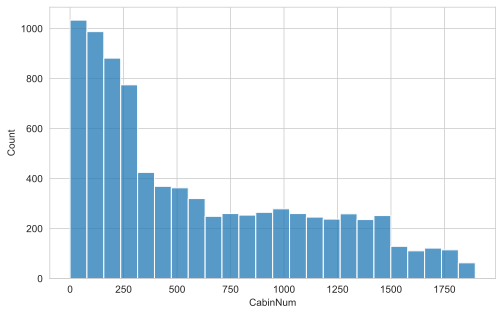

In [5]:
sns.histplot(train_df['CabinNum']);

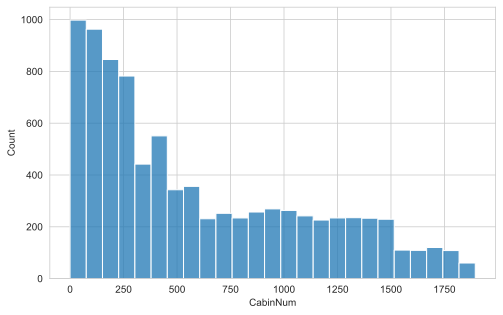

In [6]:
sns.histplot(train_df['CabinNum'].fillna(train_df['CabinNum'].median()));

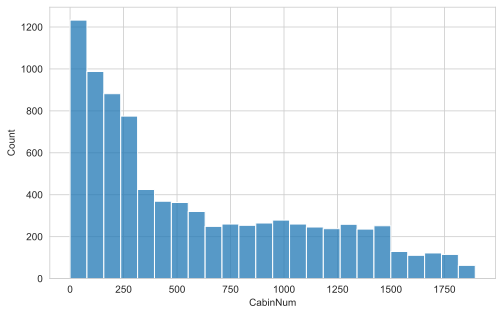

In [7]:
sns.histplot(train_df['CabinNum'].fillna(train_df['CabinNum'].value_counts()[0]));

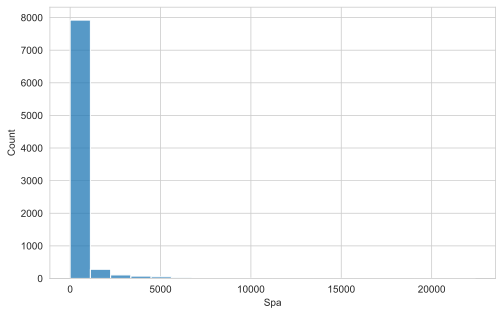

In [8]:
sns.histplot(train_df['Spa'], bins=20);

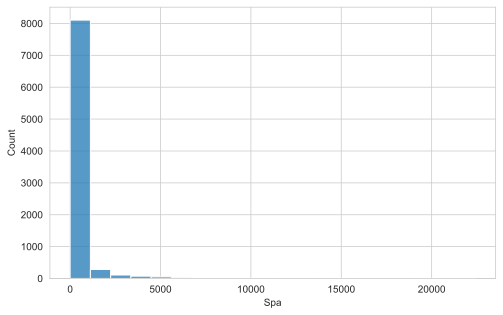

In [9]:
sns.histplot(train_df['Spa'].fillna(train_df['Spa'].median()), bins=20);

**Среди VIP-пассажиров доля телепортированных значительно меньше**

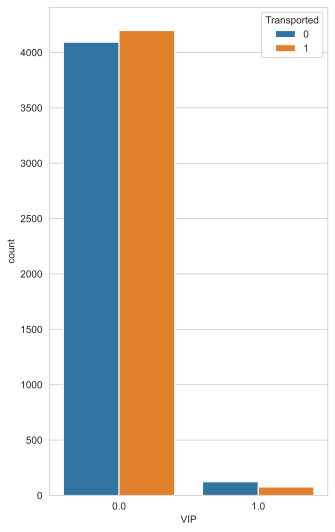

In [10]:
plt.figure(figsize=(5, 9))
sns.countplot(data=train_df, x='VIP', hue='Transported');

Строки датафрейма, содержащие пропущенные значения

In [11]:
train_df[train_df.isnull().any(axis=1)]

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
7,6,1,Earth,1.0,G,0.0,0.0,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,NaN,1
10,8,2,Europa,1.0,B,1.0,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,1
15,12,0,Earth,0.0,NaN,NaN,NaN,TRAPPIST-1e,31.0,0.0,32.0,0.0,876.0,0.0,0.0,0
16,14,0,Mars,0.0,F,3.0,1.0,55 Cancri e,27.0,0.0,1286.0,122.0,NaN,0.0,0.0,0
23,20,5,Earth,1.0,E,0.0,0.0,55 Cancri e,29.0,0.0,0.0,0.0,NaN,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,9250,0,Europa,0.0,E,597.0,1.0,TRAPPIST-1e,29.0,0.0,0.0,2972.0,NaN,28.0,188.0,1
8674,9257,0,NaN,0.0,F,1892.0,1.0,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,0
8675,9259,0,Earth,NaN,F,1893.0,1.0,TRAPPIST-1e,44.0,0.0,1030.0,1015.0,0.0,11.0,NaN,1
8684,9274,0,NaN,1.0,G,1508.0,1.0,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1


**"Ленивый метод": замена пропущенных значений в категориальных признаках на самое часто встречающееся значение, в вещественных — на медиану. TODO: пропробовать не заменять пропуски в категориальных переменных, а выносить их в отдельную dummy-переменную. TODO: попробовать KNNImputer**

Получение категориальных и числовых колонок

In [12]:
cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0] and column != 'HomePlanet']
# cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0]]

num_missing_columns = [column for column in train_df.columns if (train_df[column].dtype == np.float64 or train_df[column].dtype == np.int64) and train_df[column].count() < train_df.shape[0]]
print(cat_missing_columns)
print(num_missing_columns)

['CabinDeck', 'Destination']
['CryoSleep', 'CabinNum', 'CabinSideIsPort', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


C:\Users\dmit\AppData\Local\Temp\ipykernel_11956\3376705164.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0] and column != 'HomePlanet']


Доля пропущенных значений в категориальных признаках

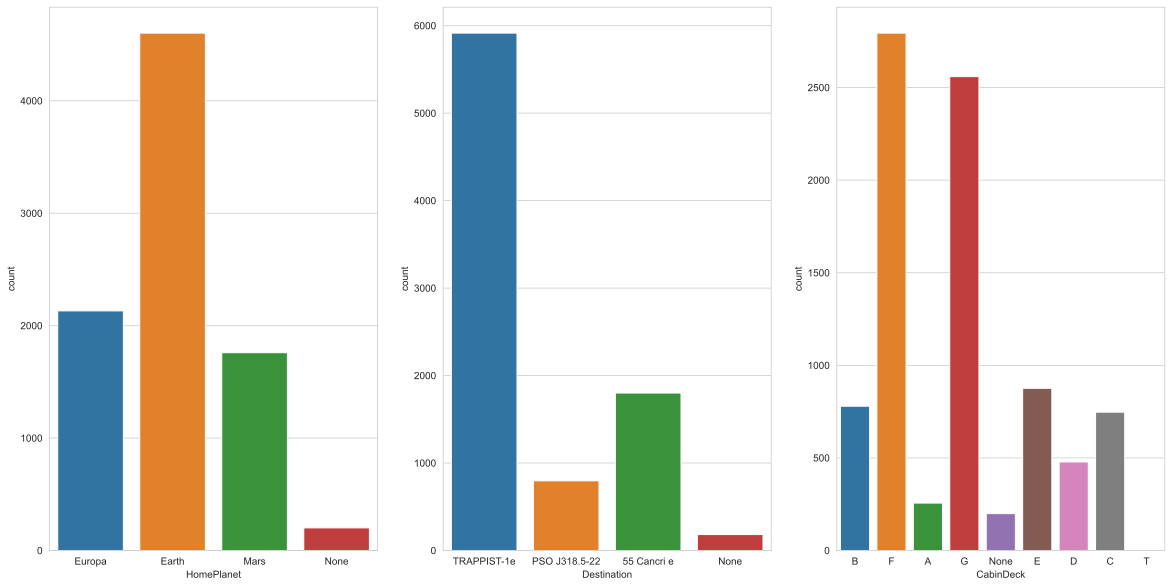

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.countplot(x=train_df['HomePlanet'].fillna('None'), ax=ax[0])
sns.countplot(x=train_df['Destination'].fillna('None'), ax=ax[1])
sns.countplot(x=train_df['CabinDeck'].fillna('None'), ax=ax[2]);

**Проверка работы SimpleImputer отдельно**

In [14]:
from sklearn.impute import SimpleImputer

cat_imp = SimpleImputer(strategy='most_frequent', copy=False)
num_imp = SimpleImputer(strategy='median', copy=False)

In [15]:
print(train_df['HomePlanet'].value_counts().index[0])
print(train_df['Destination'].value_counts().index[0])
print(train_df['Spa'].median())

Earth
TRAPPIST-1e
0.0


In [16]:
pd.concat([pd.DataFrame(cat_imp.fit_transform(train_df[cat_missing_columns])), pd.DataFrame(num_imp.fit_transform(train_df[num_missing_columns])), train_df[cat_missing_columns].isnull().any(axis=1)], axis=1)

,0,1,0,1,2,3,4,5,6,7,8,9,0
0,B,TRAPPIST-1e,0.0,0.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,F,TRAPPIST-1e,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,False
2,A,TRAPPIST-1e,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False
3,A,TRAPPIST-1e,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False
4,F,TRAPPIST-1e,0.0,1.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,A,55 Cancri e,0.0,98.0,1.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,False
8689,G,PSO J318.5-22,1.0,1499.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,False
8690,G,TRAPPIST-1e,0.0,1500.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,False
8691,E,55 Cancri e,0.0,608.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,False


**Создание ColumnTransformer. Он необходим для заполнения пропущенных значений в определённых колонках определённым способом. Полученный ColumnTransformer будет передан в pipeline, который понадобится на кросс-валидации, чтобы модель не "подсматривала" в валидационный набор данных.**

In [17]:
from sklearn.compose import ColumnTransformer

missing_ct = ColumnTransformer(
    [
        ("cat_imp", SimpleImputer(strategy='most_frequent'), cat_missing_columns),
        ("num_imp", SimpleImputer(strategy='median'), num_missing_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1)
pd.DataFrame(missing_ct.fit_transform(train_df), columns=missing_ct.get_feature_names_out())

,CabinDeck,Destination,CryoSleep,CabinNum,CabinSideIsPort,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,SameGroupCount,HomePlanet,Transported
0,B,TRAPPIST-1e,0.0,0.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,Europa,0
1,F,TRAPPIST-1e,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,2,0,Earth,1
2,A,TRAPPIST-1e,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,3,1,Europa,0
3,A,TRAPPIST-1e,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,3,1,Europa,0
4,F,TRAPPIST-1e,0.0,1.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,4,0,Earth,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,A,55 Cancri e,0.0,98.0,1.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,9276,0,Europa,0
8689,G,PSO J318.5-22,1.0,1499.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,9278,0,Earth,0
8690,G,TRAPPIST-1e,0.0,1500.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,9279,0,Earth,1
8691,E,55 Cancri e,0.0,608.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,9280,1,Europa,0


**Проверка гипотезы о том, что люди, находящиеся в одной группе, в основном летят с одной планеты**

In [18]:
grouped = train_df.groupby(by='Group')[['HomePlanet', 'SameGroupCount']].agg({'HomePlanet': [pd.Series.mode, pd.unique], 'SameGroupCount': np.max})
grouped.loc[:, ('HomePlanet', 'unique_count')] = grouped.loc[:, ('HomePlanet', 'unique')].apply(lambda s: s[~pd.isna(s)].size)
grouped

HomePlanet           SameGroupCount   HomePlanet
            mode    unique           amax unique_count
Group                                                 
1         Europa  [Europa]              0            1
2          Earth   [Earth]              0            1
3         Europa  [Europa]              1            1
4          Earth   [Earth]              0            1
5          Earth   [Earth]              0            1
...          ...       ...            ...          ...
9275      Europa  [Europa]              2            1
9276      Europa  [Europa]              0            1
9278       Earth   [Earth]              0            1
9279       Earth   [Earth]              0            1
9280      Europa  [Europa]              1            1

[6217 rows x 4 columns]

In [19]:
grouped = train_df.dropna().groupby(by='Group')[['HomePlanet', 'SameGroupCount']].agg({'HomePlanet': [pd.Series.mode, pd.unique], 'SameGroupCount': np.max})
grouped.loc[:, ('HomePlanet', 'unique_count')] = grouped.loc[:, ('HomePlanet', 'unique')].apply(lambda s: s[~pd.isna(s)].size)
grouped

HomePlanet           SameGroupCount   HomePlanet
            mode    unique           amax unique_count
Group                                                 
1         Europa  [Europa]              0            1
2          Earth   [Earth]              0            1
3         Europa  [Europa]              1            1
4          Earth   [Earth]              0            1
5          Earth   [Earth]              0            1
...          ...       ...            ...          ...
9275      Europa  [Europa]              2            1
9276      Europa  [Europa]              0            1
9278       Earth   [Earth]              0            1
9279       Earth   [Earth]              0            1
9280      Europa  [Europa]              1            1

[5111 rows x 4 columns]

In [20]:
(grouped.loc[:, ('HomePlanet', 'unique_count')] == 1).all()

True

In [21]:
# grouped = train_df.groupby(by='Group')['HomePlanet'].first(min_count=1)
# grouped

grouped = train_df.groupby(by='Group')['HomePlanet'].agg(pd.Series.mode)
grouped

Group
1       Europa
2        Earth
3       Europa
4        Earth
5        Earth
         ...  
9275    Europa
9276    Europa
9278     Earth
9279     Earth
9280    Europa
Name: HomePlanet, Length: 6217, dtype: object

In [22]:
train_df[train_df['HomePlanet'].isnull()]

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
59,64,1,NaN,1.0,E,3.0,0.0,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,119,1,NaN,0.0,A,0.0,1.0,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,210,0,NaN,1.0,D,6.0,1.0,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,242,0,NaN,0.0,F,46.0,0.0,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,251,0,NaN,1.0,C,11.0,0.0,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,9084,0,NaN,0.0,E,582.0,1.0,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,9194,1,NaN,0.0,E,603.0,0.0,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,9248,0,NaN,0.0,F,1792.0,0.0,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1
8674,9257,0,NaN,0.0,F,1892.0,1.0,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,0


In [23]:
temp_df = train_df.copy()
most_frequent_planet = pd.Series.mode(temp_df['HomePlanet'])[0]
temp_df.loc[temp_df['HomePlanet'].isnull(), 'HomePlanet'] = temp_df.loc[temp_df['HomePlanet'].isnull(), :].apply(lambda s: grouped[s[0]] if type(grouped[s[0]]) is str else most_frequent_planet, axis=1)

In [24]:
temp_df

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,Europa,0.0,B,0.0,1.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0,Earth,0.0,F,0.0,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1
2,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0
3,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0
4,4,0,Earth,0.0,F,1.0,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,0,Europa,0.0,A,98.0,1.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0
8689,9278,0,Earth,1.0,G,1499.0,0.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8690,9279,0,Earth,0.0,G,1500.0,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1
8691,9280,1,Europa,0.0,E,608.0,0.0,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0


In [25]:
train_df[train_df['HomePlanet'].isnull()]

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
59,64,1,NaN,1.0,E,3.0,0.0,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,119,1,NaN,0.0,A,0.0,1.0,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,210,0,NaN,1.0,D,6.0,1.0,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,242,0,NaN,0.0,F,46.0,0.0,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,251,0,NaN,1.0,C,11.0,0.0,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,9084,0,NaN,0.0,E,582.0,1.0,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,9194,1,NaN,0.0,E,603.0,0.0,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,9248,0,NaN,0.0,F,1792.0,0.0,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1
8674,9257,0,NaN,0.0,F,1892.0,1.0,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,0


In [26]:
temp_df[temp_df['HomePlanet'].isnull()]

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported


**Действительно, пассажиры из одной группы летят с одной планеты**

**Создадим преобразователь, который заполнит пропущенные значения планет планетами людей в этой же группе. Это необходимо для того, чтобы на пайплайне не "подсматривать" в валидационную выборку.**

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class HomePlanetImputer(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True):
        self.copy = copy

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        most_frequent_planet = pd.Series.mode(X['HomePlanet'])[0]
        if self.copy == True:
            X_copy = X.copy()
            X_copy.loc[X_copy['HomePlanet'].isnull(), 'HomePlanet'] = X_copy.loc[X_copy['HomePlanet'].isnull(), :].apply(lambda s: grouped[s[0]] if type(grouped[s[0]]) is str else most_frequent_planet, axis=1)
            return X_copy
        else:
            X.loc[X['HomePlanet'].isnull(), 'HomePlanet'] = X.loc[X['HomePlanet'].isnull(), :].apply(lambda s: grouped[s[0]] if type(grouped[s[0]]) is str else most_frequent_planet, axis=1)
            return X

In [28]:
hpi = HomePlanetImputer()
hpi.fit(train_df)
hpi.transform(train_df)

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,Europa,0.0,B,0.0,1.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0,Earth,0.0,F,0.0,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1
2,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0
3,3,1,Europa,0.0,A,0.0,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0
4,4,0,Earth,0.0,F,1.0,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,0,Europa,0.0,A,98.0,1.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0
8689,9278,0,Earth,1.0,G,1499.0,0.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8690,9279,0,Earth,0.0,G,1500.0,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1
8691,9280,1,Europa,0.0,E,608.0,0.0,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0


Добавляем преобразователь, который в рамках пайплайна из текущих данных сделает датафрейм с заданными именами колонок. Это необходимо потому, что Imputer возвращает не датафрейм, а numpy матрицу, и, следовательно, OHE не может выполнить преобразование

In [29]:
class ColumnSetter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, *_):
        return self

    def transform(self, X,
                  *_
                  ):
        return pd.DataFrame(X, columns=self.columns)


**Выделим обучающую выборку и отложенную выборку**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:, :-1], train_df['Transported'], test_size=0.3)

In [31]:
X_train

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
3255,3495,3,Europa,0.0,C,127.0,0.0,TRAPPIST-1e,34.0,0.0,0.0,6229.0,0.0,2279.0,587.0
6642,7004,0,Earth,0.0,F,1337.0,0.0,55 Cancri e,14.0,0.0,NaN,1.0,400.0,297.0,0.0
6391,6753,1,Europa,1.0,B,226.0,1.0,TRAPPIST-1e,50.0,0.0,0.0,0.0,0.0,0.0,0.0
4955,5282,2,Earth,0.0,E,337.0,0.0,TRAPPIST-1e,35.0,0.0,35.0,0.0,14.0,0.0,816.0
8653,9231,2,Mars,1.0,F,1888.0,1.0,55 Cancri e,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6413,6774,2,Earth,0.0,F,1408.0,1.0,TRAPPIST-1e,33.0,0.0,0.0,0.0,704.0,0.0,0.0
4523,4804,2,Earth,1.0,G,785.0,0.0,TRAPPIST-1e,1.0,0.0,0.0,0.0,NaN,0.0,0.0
5742,6091,1,Earth,1.0,G,988.0,1.0,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0
5435,5809,1,Earth,0.0,F,1205.0,1.0,TRAPPIST-1e,22.0,0.0,104.0,511.0,254.0,425.0,4.0


**Создание пайплайна для заполнения пропусков, нормализации числовых признаков и векторизации категориальных признаков**

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

'''
hp_imp
ColumnTransformer(
    num = num_imp (10 columns)
    cat_imp (2 columns)
)
ColumnTransformer(
    ohe (3 columns)
)

'''

imputing = ColumnTransformer(
    [
        ("num_imp", SimpleImputer(strategy='median'), num_missing_columns),
        ('cat_imp', SimpleImputer(strategy='most_frequent'), cat_missing_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1)

scaling_and_oheing = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_missing_columns + ['HomePlanet']),
        ('scaling', StandardScaler(), ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                                       'SameGroupCount'
                                       ])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1)

Cs = [
    0.078,
    0.079,
    0.08
]

final = Pipeline(
    steps=[
        ('hp_imp', HomePlanetImputer()),
        ('imputing', imputing),
        ('column_reset', ColumnSetter(
            num_missing_columns + cat_missing_columns + ['Group', 'SameGroupCount', 'HomePlanet'])),
        ('scaling_and_oheing', scaling_and_oheing),
        ('classifier', LogisticRegressionCV(random_state=17, Cs=Cs, cv=5, n_jobs=-1))
    ])
final.fit(X_train, y_train)

Pipeline(steps=[('hp_imp', HomePlanetImputer()),
                ('imputing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_imp',
                                                  SimpleImputer(strategy='median'),
                                                  ['CryoSleep', 'CabinNum',
                                                   'CabinSideIsPort', 'Age',
                                                   'VIP', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_imp',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['CabinDeck',
                                                   'Dest...
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['CabinDeck', 'Destination',
                                                   'HomePlanet']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'SameGroupCount'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegressionCV(Cs=[0.078, 0.079, 0.08], cv=5, n_jobs=-1,
                                      random_state=17))])

In [37]:
from sklearn.model_selection import cross_val_score

print(final[-1].C_)
print('roc_auc score:', roc_auc_score(y_test, final.predict(X_test)))
print('score', final.score(X_test, y_test))
cross_val_score(final, X_train, y_train, cv=5, n_jobs=-1)

[0.079]
roc_auc score: 0.7827709231018103
score 0.7829754601226994


array([0.76910435, 0.8200493 , 0.77321282, 0.79375514, 0.80115037])

In [34]:
transformed_columns = pd.DataFrame(final[:-1].transform(X_train), columns=final[:-1][-1].get_feature_names_out()).columns
pd.DataFrame(final[-1].coef_, columns=transformed_columns)

,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,Destination_55 Cancri e,Destination_PSO J318.5-22,...,FoodCourt,ShoppingMall,Spa,VRDeck,SameGroupCount,CryoSleep,CabinNum,CabinSideIsPort,VIP,Group
0,-0.107278,0.312376,0.403816,-0.060914,-0.417611,0.004348,-0.261557,-0.003475,0.225983,-0.182251,...,0.68353,0.275517,-1.589794,-1.43574,0.02439,1.325916,0.000125,-0.496557,-0.042145,0.000013


In [35]:
final[-1].get_params()

{'Cs': [0.078, 0.079, 0.08],
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 17,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}